<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/example%20-%20genomic%20Graph%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There are a lot of different official torch geometric tutorials [here](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html). You can also use other libraries from writing GNNs (Tensorflow, DGL, etc.)



# Installation

In [ ]:
! pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.0 MB/s eta 0:00:00


# Importing

In [ ]:
import os
import sys
import pickle
import random

import pandas as pd
import numpy as np
from numpy import inf
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch_geometric.utils import to_networkx, from_networkx
from torch_geometric.nn import TAGConv, GCNConv, LabelPropagation, GraphNorm

from tqdm import tqdm
from sklearn.metrics import f1_score, classification_report


DEVICE_CHOICE = "cuda"  # change to "cpu" if you want to force CPU
device = torch.device(
    DEVICE_CHOICE if (DEVICE_CHOICE == "cpu" or torch.cuda.is_available()) else "cpu"
)
print("Device:", device)


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device.type == "cuda":
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


YOUR_PATH = "./"
log_dir = os.path.join(YOUR_PATH, "logs_tagconv_onehot")
os.makedirs(log_dir, exist_ok=True)


Device: cpu


# Example

Create some simple graph

In [ ]:
# initialize empty graph
G = nx.Graph()

# add nodes and node features
G.add_nodes_from([
      (1, {'x': [0.1, 0.2, 0.3, 0.4, 0.5]}),
      (2, {'x': [0.1, 0.2, 0.3, 0.4, 0.5]}),
      (3, {'x': [0.6, 0.7, 0.8, 0.9, 1.0]}),
      (4, {'x': [1.1, 1.2, 1.3, 1.4, 1.5]}),
])

# add edges
G.add_edges_from([(1, 3), (2, 3)])

Visualize this simple graph

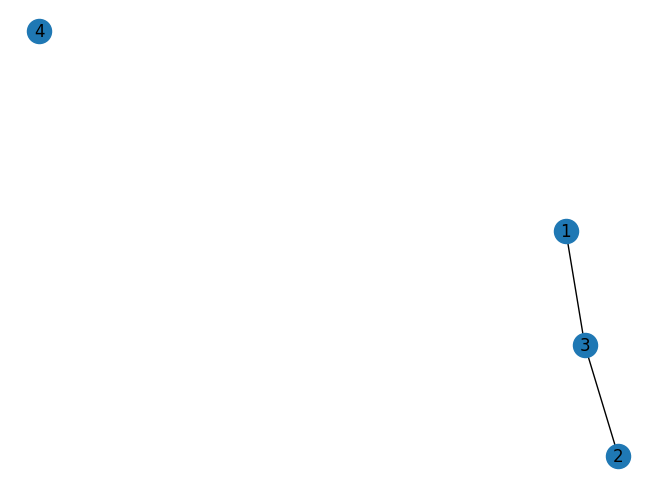

In [ ]:
nx.draw(G, with_labels=True)

Convert `nx.Graph` to torch geometric `Data` object automatically

In [ ]:
pyg_graph = from_networkx(G)
pyg_graph

Data(x=[4, 5], edge_index=[2, 4])

In [ ]:
# here is the usful feature of Data object
pyg_graph.num_features

5

Note that now edges are duplicated. Why?

In [ ]:
# directed graph?
pyg_graph.edge_index

tensor([[0, 1, 2, 2],
        [2, 2, 0, 1]])

Let's see how basic GCN layer works

In [ ]:
hidden_dim = 5

In [ ]:
gcn_layer = GCNConv(pyg_graph.num_features, hidden_dim, bias=False)

Let's see what is inside this layer

In [ ]:
for name, param in gcn_layer.named_parameters():
    print(name, param.data)

lin.weight tensor([[-0.3571, -0.2187, -0.4657,  0.0731, -0.7651],
        [ 0.6995, -0.6580,  0.5980,  0.1289, -0.2515],
        [ 0.4787,  0.1207,  0.6258,  0.0847, -0.2443],
        [ 0.2081, -0.2101,  0.3260,  0.6916,  0.4478],
        [-0.3386,  0.4471,  0.1386,  0.3934, -0.4721]])


We can see that parameters were randomly initialized. We will change them for simplicity

In [ ]:
with torch.no_grad():
    gcn_layer.lin.weight = torch.nn.Parameter(torch.ones_like(gcn_layer.lin.weight))

In [ ]:
for name, param in gcn_layer.named_parameters():
    print(name, param.data)

lin.weight tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])


Now, let's see how features of our nodes in our graph will change when we pass our graph through GCN layer

In [ ]:
with torch.no_grad():
    x = gcn_layer(pyg_graph.x, pyg_graph.edge_index)

In [ ]:
x

tensor([[2.3830, 2.3830, 2.3830, 2.3830, 2.3830],
        [2.3830, 2.3830, 2.3830, 2.3830, 2.3830],
        [2.5581, 2.5581, 2.5581, 2.5581, 2.5581],
        [6.5000, 6.5000, 6.5000, 6.5000, 6.5000]])

How did we get this output? Have a look at the formula from [documentation](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv).

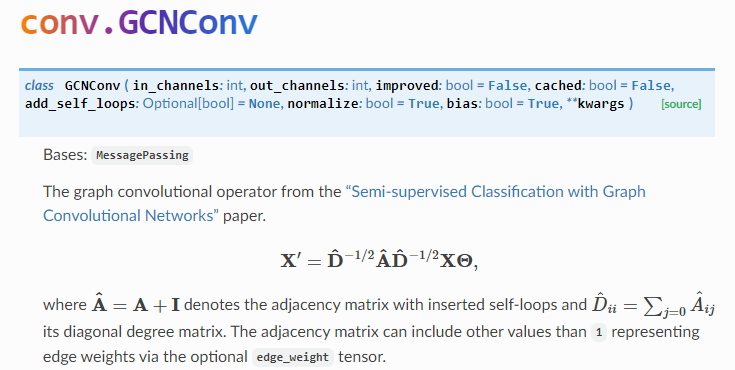

Let's write this formula from scratch. See the similarities with Symmetrically normalized Laplacian [here](https://en.wikipedia.org/wiki/Laplacian_matrix), just without self-loops

In [ ]:
def manual_gcn(G, X):
    A = nx.adjacency_matrix(G).todense()
    A_hat = A + np.identity(A.shape[0])
    D_hat = nx.laplacian_matrix(G) + A + np.identity(A.shape[0]) # The graph Laplacian is the matrix L = D - A, where A is the adjacency matrix and D is the diagonal matrix of node degrees
    TETA = np.ones((pyg_graph.num_features, hidden_dim)) # like our layer weights
    with np.errstate(divide="ignore"):
        D_hat_pow = D_hat ** -0.5 # element-wise
    D_hat_pow[D_hat_pow == inf] = 0
    return D_hat_pow @ A_hat @ D_hat_pow, D_hat_pow @ A_hat @ D_hat_pow @ X @ TETA

In [ ]:
norm_laplac, layer_output = manual_gcn(G, pyg_graph.x.numpy())

In [ ]:
layer_output # same output as from torch geometric layer

array([[2.38299317, 2.38299317, 2.38299317, 2.38299317, 2.38299317],
       [2.38299317, 2.38299317, 2.38299317, 2.38299317, 2.38299317],
       [2.55807822, 2.55807822, 2.55807822, 2.55807822, 2.55807822],
       [6.5       , 6.5       , 6.5       , 6.5       , 6.5       ]])

Let's look a little bit in detail

In [ ]:
# norm_laplac @ X @ TETA - below is first multiplier
norm_laplac

array([[0.5       , 0.        , 0.40824829, 0.        ],
       [0.        , 0.5       , 0.40824829, 0.        ],
       [0.40824829, 0.40824829, 0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 1.        ]])

In [ ]:
# norm_laplac @ X @ TETA - below is second multiplier
pyg_graph.x.numpy()

array([[0.1, 0.2, 0.3, 0.4, 0.5],
       [0.1, 0.2, 0.3, 0.4, 0.5],
       [0.6, 0.7, 0.8, 0.9, 1. ],
       [1.1, 1.2, 1.3, 1.4, 1.5]], dtype=float32)

We can notice that when we multiply `norm_laplac` by `X` we aggregate features only from local neighbors

Testing permutation equivariance. Let's create the same graph with the same features but different node labeling

In [ ]:
G_new = nx.Graph()
G_new.add_nodes_from([
      (1, {'x': [1.1, 1.2, 1.3, 1.4, 1.5]}),
      (2, {'x': [0.6, 0.7, 0.8, 0.9, 1.0]}),
      (3, {'x': [0.1, 0.2, 0.3, 0.4, 0.5]}),
      (4, {'x': [0.1, 0.2, 0.3, 0.4, 0.5]}),
])
G_new.add_edges_from([(4, 2), (3, 2)])

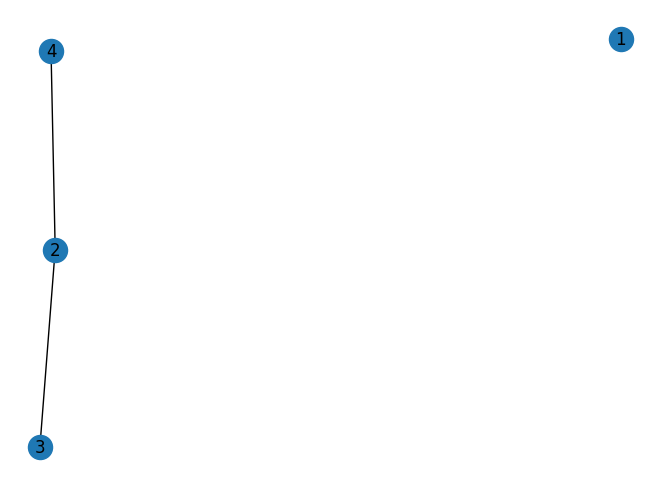

In [ ]:
nx.draw(G_new, with_labels=True)

In [ ]:
pyg_graph_new = from_networkx(G_new)

Let's check adjacency matrix from old and new graphs

In [ ]:
# old
nx.adjacency_matrix(G).todense()

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 1, 0, 0],
       [0, 0, 0, 0]])

In [ ]:
# new
nx.adjacency_matrix(G_new).todense()

array([[0, 0, 0, 0],
       [0, 0, 1, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0]])

The order of features changed as well

In [ ]:
pyg_graph.x

tensor([[0.1000, 0.2000, 0.3000, 0.4000, 0.5000],
        [0.1000, 0.2000, 0.3000, 0.4000, 0.5000],
        [0.6000, 0.7000, 0.8000, 0.9000, 1.0000],
        [1.1000, 1.2000, 1.3000, 1.4000, 1.5000]])

In [ ]:
pyg_graph_new.x

tensor([[1.1000, 1.2000, 1.3000, 1.4000, 1.5000],
        [0.6000, 0.7000, 0.8000, 0.9000, 1.0000],
        [0.1000, 0.2000, 0.3000, 0.4000, 0.5000],
        [0.1000, 0.2000, 0.3000, 0.4000, 0.5000]])

Get output from GCN layer

In [ ]:
with torch.no_grad():
    x_new = gcn_layer(pyg_graph_new.x, pyg_graph_new.edge_index)

In [ ]:
x_new

tensor([[6.5000, 6.5000, 6.5000, 6.5000, 6.5000],
        [2.5581, 2.5581, 2.5581, 2.5581, 2.5581],
        [2.3830, 2.3830, 2.3830, 2.3830, 2.3830],
        [2.3830, 2.3830, 2.3830, 2.3830, 2.3830]])

Are CNN equvariant? What about MLP and Transformers (before and after positional encoding)?

# Exercise

Imagine you are the CEO of the company that sells genetic tests. Now you want to improve the accuracy of your DNA ancestry tests by using GNNs. How can we do that? You have the database that consists of a huge amount of SNPs after using microarray genotyping for each person. You decide to shrink all that data down by utilizing HMM that identifies common IBD regions between each pair of individuals, you calculate the total length of all common IBD segments between each pair of individuals in your database and construct IBD graph where edge between two individuals exists only if the length of all common IBD segments bigger than some threshold. Now you have such an IBD graph for your whole database. In order to train your NN correctly you need at least training and validation datasets. However, you need to mimic the situation when a new customer arrives and you need to calculate edges between the new client and your database for them each. Thus, you decide to split all your vertices in two parts: those that are designated for training (train nodes) and those that are for validation (valid nodes). Then you construct graph for training as a subgraph of initial graph with train nodes but for each valid node you construct its own graph as subgraph of initial graph with train nodes **+1 valid node**. For simplicity you can calculate features for each node directly from the graph: number of edges from current node to the neighbors per class (population group), mean edge weight of edges from current node to the neighbors per class, std of edge weights per class etc. Finally, you need to predict the population group for a group of new clients.

We already prepared the data for you, you just need to train your GNN properly. Follow the instructions below.



Load files:

*   `train_graphs` - array of graphs for training GNN (actually, it's one graph)
*   `valid_graphs` - you will validate your model on these graphs during training
*   `unknown_graphs` - you need to predict labels for specific nodes in these graphs - **that will be you final answer**



In [ ]:
YOUR_PATH = '/content/drive/MyDrive/genomic_workshop_ml_in_bioinf_2024'

with open(f'/kaggle/input/ml-in-bioinformatics-2025-hse/train_graphs.pickle', 'rb') as handle:
    train_graphs = pickle.load(handle)

with open(f'/kaggle/input/ml-in-bioinformatics-2025-hse/validation_graphs.pickle', 'rb') as handle:
    valid_graphs = pickle.load(handle)

with open(f'/kaggle/input/ml-in-bioinformatics-2025-hse/test_graphs.pickle', 'rb') as handle:
    unknown_graphs = pickle.load(handle)

Examine data

In [ ]:
print(f'We have {len(train_graphs)} graph for training, {len(valid_graphs)} graph for validation and {len(unknown_graphs)} graphs where we need to predict label for vertex with unknown population group.')

We have 2782 graph for training, 926 graph for validation and 925 graphs where we need to predict label for vertex with unknown population group.


Check the structure of those arrays of graphs. Note that graphs for validation and unknown graphs have just one vertex more than training graph, that's the requerements of our task. The number of edges has no any limits and may vary. Remember that we simulate behaviour of real company: we have our database (`train_graphs` which is actually array with one graph, we will use this graph to train our model, and `valid_graphs` which are train graph with one more different node added each, we know labels for all nodes in each graph in `valid_graphs` but we want to compute quality metrics only for those newly added nodes in order to mimic new customers that came to our company), than we train our GNN on `train_graphs` and validate on `valid_graphs`, after finding the model that gave us best scores on `valid_graphs`, we use that model to predict labels for unknown nodes in `unknown_graphs` - the last thing is the end of the task. For graphs in `unknown_graphs` we know labels for all nodes except one (this is your target node), the class of this node has been marked as `-1`, this is the last node in each graph. Here is the explanation of parameters in `Data` object:

*   `x` - features of each node (row `0` in `x` has features for node `0`, row `1` in `x` has features for node `1` etc.), those features were calculated based on the same graph because IBD graphs don't have node features
*   `edge_index` - edges between nodes (already duplicated)
*   `y` - labels (population groups) of each node, ordered the same as features in `x`
*   `weight` - edge weights, have the same ordering as `x` (may be helpful in some cases)
*   `mask` - in our task it's always boolean array where all values are True, however, you can modify it, hide some nodes during loss computation phase and see how it affects  performance
*   `num_classes` - int, total amount of unique labels







In [ ]:
train_graphs[:10]

[Data(x=[2782, 4], edge_index=[2, 58030], y=[2782], weight=[58030], mask=[2782], correct_and_smooth_mask=[2782], num_classes=4),
 Data(x=[2782, 4], edge_index=[2, 58030], y=[2782], weight=[58030], mask=[2782], correct_and_smooth_mask=[2782], num_classes=4),
 Data(x=[2782, 4], edge_index=[2, 58030], y=[2782], weight=[58030], mask=[2782], correct_and_smooth_mask=[2782], num_classes=4),
 Data(x=[2782, 4], edge_index=[2, 58030], y=[2782], weight=[58030], mask=[2782], correct_and_smooth_mask=[2782], num_classes=4),
 Data(x=[2782, 4], edge_index=[2, 58030], y=[2782], weight=[58030], mask=[2782], correct_and_smooth_mask=[2782], num_classes=4),
 Data(x=[2782, 4], edge_index=[2, 58030], y=[2782], weight=[58030], mask=[2782], correct_and_smooth_mask=[2782], num_classes=4),
 Data(x=[2782, 4], edge_index=[2, 58030], y=[2782], weight=[58030], mask=[2782], correct_and_smooth_mask=[2782], num_classes=4),
 Data(x=[2782, 4], edge_index=[2, 58030], y=[2782], weight=[58030], mask=[2782], correct_and_smoo

Let's look at the class balance in training data

In [ ]:
population_groups, counts = np.unique(train_graphs[0].y.numpy(), return_counts=True)
print(f'Here is our population groups: {population_groups}')
print(f'Here is amount of vertices per each population group respectively: {counts}')

Here is our population groups: [0 1 2 3]
Here is amount of vertices per each population group respectively: [952 476 950 404]


In [ ]:
valid_graphs[:10]

[Data(x=[2783, 4], edge_index=[2, 58060], y=[2783], weight=[58060], mask=[2783], correct_and_smooth_mask=[2783], num_classes=4),
 Data(x=[2783, 4], edge_index=[2, 58052], y=[2783], weight=[58052], mask=[2783], correct_and_smooth_mask=[2783], num_classes=4),
 Data(x=[2783, 4], edge_index=[2, 58066], y=[2783], weight=[58066], mask=[2783], correct_and_smooth_mask=[2783], num_classes=4),
 Data(x=[2783, 4], edge_index=[2, 58068], y=[2783], weight=[58068], mask=[2783], correct_and_smooth_mask=[2783], num_classes=4),
 Data(x=[2783, 4], edge_index=[2, 58044], y=[2783], weight=[58044], mask=[2783], correct_and_smooth_mask=[2783], num_classes=4),
 Data(x=[2783, 4], edge_index=[2, 58050], y=[2783], weight=[58050], mask=[2783], correct_and_smooth_mask=[2783], num_classes=4),
 Data(x=[2783, 4], edge_index=[2, 58056], y=[2783], weight=[58056], mask=[2783], correct_and_smooth_mask=[2783], num_classes=4),
 Data(x=[2783, 4], edge_index=[2, 58052], y=[2783], weight=[58052], mask=[2783], correct_and_smoo

In [ ]:
unknown_graphs[:10]

[Data(x=[2783, 4], edge_index=[2, 58066], y=[2783], weight=[58066], mask=[2783], correct_and_smooth_mask=[2783], num_classes=4),
 Data(x=[2783, 4], edge_index=[2, 58056], y=[2783], weight=[58056], mask=[2783], correct_and_smooth_mask=[2783], num_classes=4),
 Data(x=[2783, 4], edge_index=[2, 58068], y=[2783], weight=[58068], mask=[2783], correct_and_smooth_mask=[2783], num_classes=4),
 Data(x=[2783, 4], edge_index=[2, 58074], y=[2783], weight=[58074], mask=[2783], correct_and_smooth_mask=[2783], num_classes=4),
 Data(x=[2783, 4], edge_index=[2, 58056], y=[2783], weight=[58056], mask=[2783], correct_and_smooth_mask=[2783], num_classes=4),
 Data(x=[2783, 4], edge_index=[2, 58056], y=[2783], weight=[58056], mask=[2783], correct_and_smooth_mask=[2783], num_classes=4),
 Data(x=[2783, 4], edge_index=[2, 58082], y=[2783], weight=[58082], mask=[2783], correct_and_smooth_mask=[2783], num_classes=4),
 Data(x=[2783, 4], edge_index=[2, 58070], y=[2783], weight=[58070], mask=[2783], correct_and_smoo

We can treat `Data` object as a dictionary, you can fing more information about that class in [manual](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html). Here is how to access

In [ ]:
# this is your trainign graph
train_graphs[0]

Data(x=[2782, 4], edge_index=[2, 58030], y=[2782], weight=[58030], mask=[2782], correct_and_smooth_mask=[2782], num_classes=4)

In [ ]:
# this is your features
train_graphs[0].x

tensor([[0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.2500, 0.2500, 0.2500, 0.2500]], dtype=torch.float64)

In [ ]:
train_graphs[0].x.shape

torch.Size([2782, 4])

In [ ]:
# this is your edges between vertices
train_graphs[0].edge_index

tensor([[   0,    0,    0,  ..., 2781, 2781, 2781],
        [  34,   38,  216,  ..., 1431, 1640, 2373]])

In [ ]:
train_graphs[0].edge_index.shape

torch.Size([2, 58030])

In [ ]:
# here is total number of population groups (labels)
train_graphs[0].num_classes

4

or add/remove parameters there

In [ ]:
# add new attribute
train_graphs[0].useless_parameter = 123

In [ ]:
# check that new attribute has been added correctly
train_graphs[0]

Data(x=[2782, 4], edge_index=[2, 58030], y=[2782], weight=[58030], mask=[2782], correct_and_smooth_mask=[2782], num_classes=4, useless_parameter=123)

In [ ]:
# remove that new attrubute
train_graphs[0].useless_parameter = None

In [ ]:
# check that new attribute has been removed correctly
train_graphs[0]

Data(x=[2782, 4], edge_index=[2, 58030], y=[2782], weight=[58030], mask=[2782], correct_and_smooth_mask=[2782], num_classes=4)

Check that core of all graphs is the same. We need to convert `Data` object from Torch Geometric to `nx.Graph` object because only `networkx` library has the function to check graph isomorphism. [Here](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/utils/convert.html) are some useful Torch Geometric utils (including `to_networkx` function, that has a lot of interesting parameters)

In [ ]:
train_graph_nx = to_networkx(train_graphs[0])

In [ ]:
print(f'Diameter of the training graph is: {nx.diameter(train_graph_nx)}')

Diameter of the training graph is: 4


In [ ]:
print(f'Is directed: {train_graph_nx.is_directed()}, number of edges: {train_graph_nx.number_of_edges()}, number of nodes: {train_graph_nx.number_of_nodes()}')

Is directed: True, number of edges: 58030, number of nodes: 2782


In [ ]:
train_graph_nx = nx.Graph(train_graph_nx)

In [ ]:
print(f'Is directed: {train_graph_nx.is_directed()}, number of edges: {train_graph_nx.number_of_edges()}, number of nodes: {train_graph_nx.number_of_nodes()}')

Is directed: False, number of edges: 29015, number of nodes: 2782


In [ ]:
# this may run up to 15 min long, it is not necessary for the task, you can skip it
for graph in valid_graphs[:5]:
    nx_graph = nx.Graph(to_networkx(graph))
    nx_graph = nx_graph.subgraph([i for i in range(train_graph_nx.number_of_nodes())])
    assert nx.vf2pp_is_isomorphic(nx_graph, train_graph_nx, node_label=None)

In [ ]:
# this may run up to 5 min long, it is not necessary for the task, you can skip it
for graph in unknown_graphs[:5]:
    nx_graph = nx.Graph(to_networkx(graph))
    nx_graph = nx_graph.subgraph([i for i in range(train_graph_nx.number_of_nodes())])
    assert nx.vf2pp_is_isomorphic(nx_graph, train_graph_nx, node_label=None)

Define GNN model. Hints: use `TAGConv` layers and `ELU` activation function, don't use large hidden size, `512` is upper limit. Also, `Data(...).num_features` will give you 2-nd dimention of you features which is useful for stacking layers. You can convert your torch tensors to float dtype by using `.float()`. [Here](https://pytorch-geometric.readthedocs.io/en/latest/cheatsheet/gnn_cheatsheet.html) is the list of all layers available in torch geometric.

In [ ]:
class GL_TAGConv_3l_512h_w_k3_gnorm(torch.nn.Module):
    def __init__(self, data):
        super(GL_TAGConv_3l_512h_w_k3_gnorm, self).__init__()
        self.conv1 = TAGConv(int(data.num_features), 512)
        self.conv2 = TAGConv(512, 512)
        self.conv3 = TAGConv(512, int(data.num_classes))
        self.n1 = GraphNorm(512)
        self.n2 = GraphNorm(512)

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = self.n1(x)
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.n2(x)
        x = self.conv3(x, edge_index, edge_attr)
        return x

Validation function

In [ ]:
def evaluate_on_valid():
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for sample in tqdm(valid_graphs, desc='[Eval] Valid graphs', leave=False):
            sample = sample.to(device)
            logits = model(sample)
            idx = sample.y.shape[0] - 1
            pred = int(torch.argmax(logits[idx]).item())
            true = int(sample.y[idx].item())
            y_pred.append(pred)
            y_true.append(true)
    f1m = f1_score(y_true, y_pred, average='macro')
    return f1m, y_true, y_pred

Initialize model, loss and optimizer. Remember, we solve single-label classification problem

In [ ]:
model = GL_TAGConv_3l_512h_w_k3_gnorm(train_graphs[0]).to(device)
print(model)

GL_TAGConv_3l_512h_w_k3_gnorm(
  (conv1): TAGConv(4, 512, K=3)
  (conv2): TAGConv(512, 512, K=3)
  (conv3): TAGConv(512, 4, K=3)
  (n1): GraphNorm(512)
  (n2): GraphNorm(512)
)


Training loop

In [ ]:
# Hyperparameters
learning_rate = 0.0001
weight_decay  = 0.0001
num_epochs    = 2
patience      = 1  # simple early stopping

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=50, gamma=0.95)

best_val_f1 = 0.0
patience_counter = 0
best_path = os.path.join(log_dir, 'model_best.bin')

print(f"Start training for {num_epochs} epochs")
for epoch in range(1, num_epochs + 1):
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch-1} (patience reached).")
        break

    # Evaluate at start of epoch (like Trainer)
    val_f1, y_true_val, y_pred_val = evaluate_on_valid()
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), best_path)
        print(f"[Epoch {epoch:03d}] val_f1_macro improved to {best_val_f1:.4f} — saved model_best.bin")
    else:
        patience_counter += 1
        print(f"[Epoch {epoch:03d}] val_f1_macro={val_f1:.4f} (no improvement, patience={patience_counter})")

    # Train one epoch across all training graphs
    model.train()
    losses = []
    for sample in tqdm(train_graphs, desc=f'[Train] Epoch {epoch:03d}', leave=False):
        sample = sample.to(device)
        optimizer.zero_grad()
        out = model(sample)
        loss = criterion(out[-1], sample.y[-1])
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.append(float(loss.detach().cpu().item()))

    print(f"[Epoch {epoch:03d}] mean_loss={np.mean(losses):.6f}")

Start training for 3 epochs


[Epoch 001] val_f1_macro improved to 0.1730 — saved model_best.bin


[Epoch 001] mean_loss=0.647771


[Epoch 002] val_f1_macro improved to 0.6731 — saved model_best.bin


[Epoch 002] mean_loss=0.602912


[Epoch 003] val_f1_macro improved to 0.6804 — saved model_best.bin


[Epoch 003] mean_loss=0.598144


In [ ]:
if os.path.exists(best_path):
    model.load_state_dict(torch.load(best_path, map_location=device))
    print(f"Loaded best checkpoint from: {best_path}")
else:
    print("No best checkpoint found; using current weights.")

final_f1, y_true_val, y_pred_val = evaluate_on_valid()
print(f"Final validation f1_macro: {final_f1:.6f}")
print(classification_report(y_true_val, y_pred_val, digits=4))

Loaded best checkpoint from: ./logs_tagconv_onehot/model_best.bin


Final validation f1_macro: 0.680394
              precision    recall  f1-score   support

           0     0.7014    0.7855    0.7411       317
           1     0.5781    0.4684    0.5175       158
           2     0.8731    0.8924    0.8826       316
           3     0.6167    0.5481    0.5804       135

    accuracy                         0.7333       926
   macro avg     0.6923    0.6736    0.6804       926
weighted avg     0.7266    0.7333    0.7278       926



Testing on unknown nodes

In [ ]:
model.eval()
test_ids, test_preds = [], []
with torch.no_grad():
    for i, sample in enumerate(tqdm(unknown_graphs, desc='[Test] Inference')):
        sample = sample.to(device)
        logits = model(sample)
        idx = sample.y.shape[0] - 1
        pred = int(torch.argmax(logits[idx]).item())
        test_ids.append(i)           # matches "graph_{i}" id convention
        test_preds.append(pred)

submission_path = os.path.join(YOUR_PATH, "submission.csv")
sub_df = pd.DataFrame({"ID": test_ids, "PREDICTED_CLASS": test_preds}).sort_values("ID").reset_index(drop=True)
sub_df.to_csv(submission_path, index=False)
print("Saved submission to:", submission_path)
print(sub_df.head(10).to_string(index=False))

[Test] Inference: 100%|██████████| 925/925 [00:19<00:00, 46.27it/s]

Saved submission to: ./submission.csv
 ID  PREDICTED_CLASS
  0                0
  1                3
  2                3
  3                0
  4                1
  5                1
  6                3
  7                0
  8                3
  9                1


**Your task is to improve this baseline submission**.

To improve prediction quality, you can enrich the graph node features with additional structural information, for example by adding centrality measures or analyzing hub nodes in the network. Another direction is to move beyond standard cross-entropy and train the model with contrastive objectives such as **Triplet Loss**, which encourage better separation of classes in the embedding space. A fast and correct implementation of online triplet mining is available in **TensorFlow Addons**, which makes it straightforward to experiment with this type of training (need to be casted from tensorflow to pytorch syntax).


You can try to investigate why your model returns particular predictions using Captum

In [ ]:
! pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 5.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.3 MB/s eta 0:00:00:00:0100:01
  Attempting unins

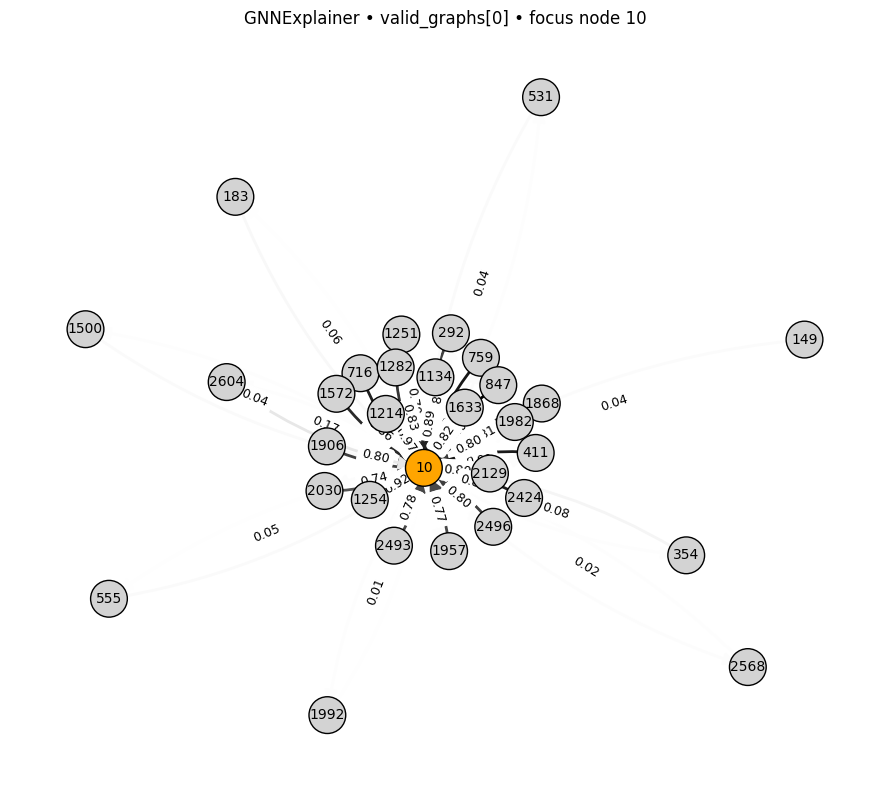

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

candidates = []
if 'valid_graphs' in globals() and len(valid_graphs) > 0:
    candidates.append(('valid_graphs', valid_graphs))
if 'train_graphs' in globals() and len(train_graphs) > 0:
    candidates.append(('train_graphs', train_graphs))
if 'unknown_graphs' in globals() and len(unknown_graphs) > 0:
    candidates.append(('unknown_graphs', unknown_graphs))
if not candidates:
    raise RuntimeError("No graphs found in valid_graphs / train_graphs / unknown_graphs.")

source_name, graphs = candidates[0]
g_idx = 0 # change this if you want another graph
g = graphs[g_idx]

device = torch.device(globals().get('DEVICE', 'cuda' if torch.cuda.is_available() else 'cpu'))
g = g.to(device)

# Edge attributes (your model expects 'weight')
edge_attr = getattr(g, 'weight', getattr(g, 'edge_attr', None))
if edge_attr is None:
    edge_attr = torch.ones(g.edge_index.size(1), dtype=torch.float32, device=device)
else:
    edge_attr = edge_attr.float()

# 4) Model: reuse if present; otherwise instantiate your class for this graph
if 'model' in globals():
    model = model.to(device).eval()
else:
    # Assumes GL_TAGConv_3l_512h_w_k3_gnorm is already defined in your notebook
    model = GL_TAGConv_3l_512h_w_k3_gnorm(g).to(device).eval()
    print("Note: 'model' was not found; created a fresh (untrained) instance for visualization.")

# 5) Thin wrapper so Explainer can call model(x, edge_index, edge_attr)
class _Wrapper(torch.nn.Module):
    def __init__(self, core):
        super().__init__()
        self.core = core
    def forward(self, x, edge_index, edge_attr):
        return self.core(Data(x=x, edge_index=edge_index, weight=edge_attr))

wrapped = _Wrapper(model).eval()

focus_node = 10 # change this if you want another node

explainer = Explainer(
    model=wrapped,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='raw',  # change to 'log_probs' if your model returns log-softmax
    ),
)

gnn_exp = explainer(x=g.x, edge_index=g.edge_index, edge_attr=edge_attr, index=focus_node)
sub = gnn_exp.get_explanation_subgraph()
ei, ew = sub.edge_index.detach().cpu(), sub.edge_mask.detach().float().cpu()


def _offset_edge_labels(texts, pos, dist=0.12, strength=0.8):
    for (u, v), t in texts.items():
        if u not in pos or v not in pos:
            continue
        vec = pos[v] - pos[u]
        nrm = np.linalg.norm(vec)
        if nrm == 0:
            continue

        dx, dy = vec[1] / nrm, -vec[0] / nrm
        x, y = t.get_position()
        t.set_position((x + strength * dist * dx, y + strength * dist * dy))

def show_node_explanation(edge_index, edge_weight, node_id):
    # Keep only edges incident to node_id
    mask = (edge_index[0] == node_id) | (edge_index[1] == node_id)
    ei = edge_index[:, mask]
    ew = edge_weight[mask]

    # Normalize importances for coloring
    if ew.numel() > 0:
        ew = (ew - ew.min()) / (ew.max() - ew.min() + 1e-12)
    else:
        ew = torch.zeros_like(ew)

    G = nx.DiGraph()
    nodes = torch.unique(ei.view(-1)).tolist()
    G.add_nodes_from(nodes)
    for (src, dst), w in zip(ei.t().tolist(), ew.tolist()):
        G.add_edge(src, dst, weight=w, label=f"{w:.2f}")

    pos = nx.spring_layout(G, seed=0)

    plt.figure(figsize=(9, 8))
    node_colors = ['orange' if n == node_id else 'lightgray' for n in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=700, edgecolors='black')
    nx.draw_networkx_labels(G, pos, font_size=10)

    edges = list(G.edges)
    weights = [G[u][v]['weight'] for u, v in edges] if edges else []
    nx.draw_networkx_edges(
        G, pos, edgelist=edges, width=2.0,
        edge_color=weights, edge_cmap=plt.cm.Greys,
        connectionstyle='arc3,rad=0.12', arrows=True, arrowsize=18
    )

    texts = nx.draw_networkx_edge_labels(
        G, pos, edge_labels=nx.get_edge_attributes(G, 'label'),
        label_pos=0.5, font_size=9
    )
    _offset_edge_labels(texts, pos)

    plt.title(f"GNNExplainer • {source_name}[{g_idx}] • focus node {node_id}", fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

show_node_explanation(ei, ew, node_id=focus_node)

Visualize predictions. The node that is bigger than others is your target node.

In [ ]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def visualize_predictions(model, test_graph, number_of_classes, use_component=False):
    '''
    Function that helps visually compare predictions from the model with grounnd truth values

    Parameters
    model: your trained model
    test_graph: Data(...) object from torch geometric
    number_of_classes: num_classes in Data(...) object
    use_component: if True, will draw the whole component with target node, otherwise (if False) will draw only target node and neighbors of target node
    '''
    preds = np.argmax(F.softmax(model(test_graph), dim=1).cpu().detach().numpy(), axis=-1)

    graph = to_networkx(test_graph, edge_attrs=['weight'], node_attrs=['y', 'mask'], to_undirected=True)
    print(f'Number of initial nodes: {len(graph)}')
    last_node_id = len(graph)-1
    pred_attrs = {i:{'predict':p} for i, p in enumerate(preds)}
    nx.set_node_attributes(graph, pred_attrs)

    if use_component:
        print(f'Number of connected components:{nx.number_connected_components(graph)}')
        for c in nx.connected_components(graph):
            if len(graph)-1 in c:
                test_node_neighbors = list(c)
                break
    else:
        test_node_neighbors = list(graph.neighbors(len(graph)-1)) + [len(graph)-1]

    graph = nx.subgraph(graph, test_node_neighbors)
    print(f'Number of final nodes: {len(graph)}')
    node_classes = [f'P{i}' for i in range(number_of_classes)]
    if -1 in test_graph.y:
        node_classes.append('unknown')

    cmap = mpl.colormaps['jet']
    px = 1 / plt.rcParams['figure.dpi']
    colors = cmap(np.linspace(0, 1, len(np.unique(node_classes))))

    pos = nx.spring_layout(graph, iterations=10)
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(1400 * px, 600 * px))
    ax1.axis('off')
    ax2.axis('off')
    ax2.set_title(f'Ground truth')
    ax1.set_title(f'Prediction')

    y = list(nx.get_node_attributes(graph,'y').values())
    mask = np.array(list(nx.get_node_attributes(graph,'mask').values()))
    preds = list(nx.get_node_attributes(graph,'predict').values())

    current_node_colors = []
    real_node_colors = []

    for cls in y:
        real_node_colors.append(colors[cls])

    for cls in preds:
        current_node_colors.append(colors[cls])

    if np.sum(~mask) == 0:
        nx.draw_networkx_nodes(graph, pos=pos, node_color=current_node_colors, node_size=[24 if node != last_node_id else 150 for node in graph.nodes], ax=ax1)
    else:
        print('Using masks')
        assert np.all(np.array(list(graph)) == np.array(list(graph.nodes)))
        nx.draw_networkx_nodes(graph, pos=pos, nodelist=np.array(list(graph))[mask], node_color=np.array(current_node_colors)[mask], node_size=[24 if node != last_node_id else 150 for node in np.array(list(graph))[mask]], ax=ax1)
        nx.draw_networkx_nodes(graph, pos=pos, nodelist=np.array(list(graph))[~mask], node_shape='s', node_color=np.array(current_node_colors)[~mask], node_size=[24 if node != last_node_id else 150 for node in np.array(list(graph))[~mask]], ax=ax1)
    nx.draw_networkx_nodes(graph, pos=pos, node_color=real_node_colors, node_size=[24 if node != last_node_id else 150 for node in graph.nodes], ax=ax2)

    edges, weights = zip(*nx.get_edge_attributes(graph,'weight').items())

    new_cmap = truncate_colormap(plt.cm.Blues, 0.2, 1.0)
    nx.draw_networkx_edges(graph, pos=pos, alpha=0.5, width=1, edge_cmap=new_cmap, edge_color=weights, ax=ax1)
    nx.draw_networkx_edges(graph, pos=pos, alpha=0.5, width=1, edge_cmap=new_cmap, edge_color=weights, ax=ax2)

    for i, clr in enumerate(colors):
        ax1.scatter([],[], c=clr, label=f'{node_classes[i]}')
        ax2.scatter([],[], c=clr, label=f'{node_classes[i]}')

    ax1.legend(prop={'size': 6})
    ax2.legend(prop={'size': 6})

    plt.show()

In [ ]:
itm = 10

Number of initial nodes: 2783
Number of final nodes: 32


/tmp/ipykernel_36/518256699.py:81: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter([],[], c=clr, label=f'{node_classes[i]}')
/tmp/ipykernel_36/518256699.py:82: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter([],[], c=clr, label=f'{node_classes[i]}')


<Figure size 640x480 with 0 Axes>

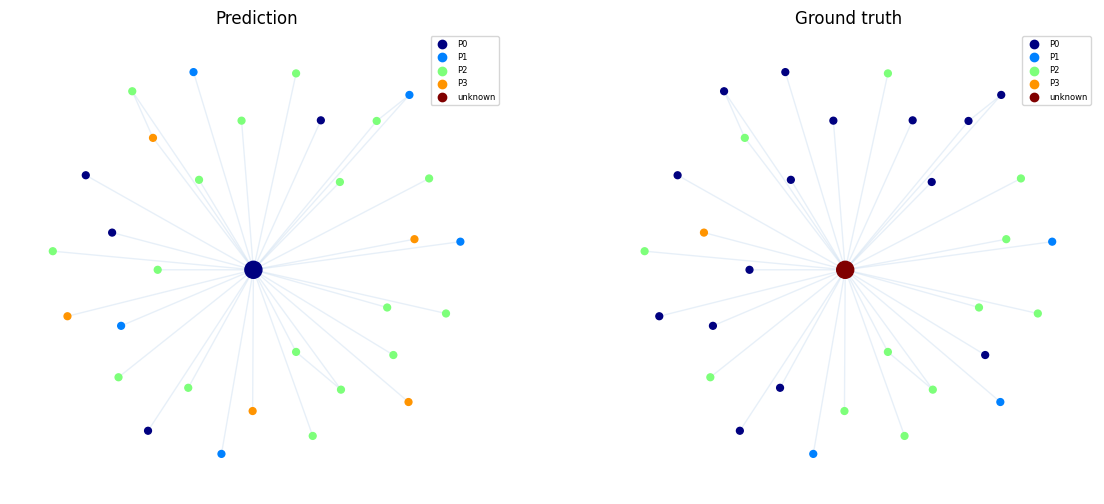

In [ ]:
visualize_predictions(model, unknown_graphs[itm], unknown_graphs[itm].num_classes, use_component=False)

Number of initial nodes: 2783
Number of final nodes: 27


/tmp/ipykernel_36/518256699.py:81: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter([],[], c=clr, label=f'{node_classes[i]}')
/tmp/ipykernel_36/518256699.py:82: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter([],[], c=clr, label=f'{node_classes[i]}')


<Figure size 640x480 with 0 Axes>

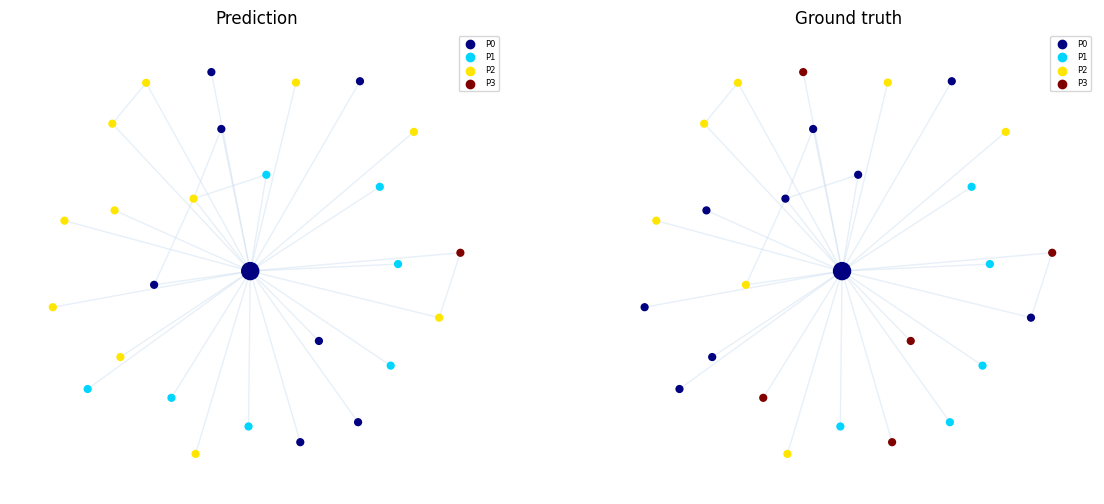

In [ ]:
visualize_predictions(model, valid_graphs[itm], valid_graphs[itm].num_classes, use_component=False)

Here is example of non AI algorithm

Label Propagation

In [ ]:
label_propagation_model = LabelPropagation(num_layers=3, alpha=0.5)

In [ ]:
whatever_class = 0
preds = []
for graph in unknown_graphs:
    node_mask = [True] * (len(graph.y)-1) + [False]
    preds.append(label_propagation_model(y=torch.tensor(graph.y.cpu().numpy().tolist()[:-1] + [whatever_class]).long(), mask=node_mask,  edge_index=graph.edge_index).argmax(dim=-1)[-1])

In [ ]:
preds

What about Spectral Clustering?